## English Wikipedia Traffic: Dec. 2007 - Sept. 2018

Here, I retrieve English Wikipedia's traffic data from Wikimedia's REST API between December 2007 and September 2018. The data is grouped by access medium, desktop and mobile. I then clean, aggegrate, and display the traffic patterns by medium over time. This work is intended to be fully reproducible.

### Setup
First, we will import the packages necessary to run the following code.

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Acquistion
The code in this section leverages API call code found [here](http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb).
We will pull data from two API endpoints: the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and the [Pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). These endpoints represent two different methods of collecting website traffic, Pageviews is the replacement of Legacy Pagecounts with some time overlap.

Here we define:
* The API endpoints
* Create a parameter called headers to pass to the API calls
* Define an API call function to retrieve and format data, given the API's defined parameters

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Customize these with your own information
headers = {'User-Agent': 'https://github.com/mag3141592',
           'From': 'starkm5@uw.edu'}

# API call to retrieve data and return as a JSON
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

#### Legacy Pagecount API

Here we define a function to compile the legacy pagecount parameters needed to pass to the REST API. See more available parameter options [here](https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end).

In [3]:
# This function takes the start and end strings formatted as YYYYMMDDHH and an access type string 
def params_legacy(start, end, access_type):
    parameters = {"project" : "en.wikipedia.org",
                 "access-site" : access_type,
                 "granularity" : "monthly",
                 "start" : start,
                 "end" : end  # Use 1st day of month following final month of data
                 }
    return parameters

Here I loop over 2 access types and call the params_legacy() function to compile my parameters. Then I pass the parameters into the api_call() function, defined above, which retrieves the data and formats it as a JSON. It saves the API response to a dictionary and outputs a file.

In [4]:
# Defines legacy access types to loop over
access_type_legacy = ['desktop-site', 'mobile-site']

# Create empty dictionary to store results
legacy = dict()

for access in access_type_legacy:
   
    # Defines parameters and call API
    start = '2007120100'
    end = '2016080100'
    api_response = api_call(endpoint_legacy, params_legacy(start, end, access))
    
    # Output filename
    filename = 'data/pagecounts_' + access + '_' + start[0:6] + '-' + end[0:6] + '.json'
    
    # Saves necessary response variables, count and timestamp, to dictionary
    col_name = access
    legacy[col_name] = pd.DataFrame(api_response['items'])[['count', 'timestamp']]
    
    # Saves raw API response to JSON file.
    with open(filename, 'w') as outfile:
        json.dump(api_response, outfile)     
    print('Data saved to ' + filename)

Data saved to data/pagecounts_desktop-site_200712-201608.json
Data saved to data/pagecounts_mobile-site_200712-201608.json


Next we basically repeat the process used for the Legacy Pagecounts API for the Pageviews API.

#### Pageviews API

Here we define a function to compile the pageviews parameters needed to pass to the REST API. See more available parameter options [here](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end).

In [5]:
# This function takes the start and end strings formatted as YYYYMMDDHH and an access type string 
def params_pageviews(start, end, access_type):
    parameters = {"project" : "en.wikipedia.org",
                    "access" : access_type,
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : start,
                    "end" : end  # Use 1st day of month following final month of data
                 }
    return parameters

Here I loop over 3 access types and call the params_pageviews() function to compile my parameters. Then I pass the parameters into the api_call() function, defined above, which retrieves the data and formats it as a JSON. It saves the API response to a dictionary and outputs a file.

In [6]:
# Defines Pageviews access types to loop over
access_type_pageviews = ["desktop", "mobile-app", "mobile-web"]

# Create empty dictionary to store results
pageviews = dict()

for access in access_type_pageviews:

    # Defines parameters and call API
    start = '2015070100'
    end = '2018100100'
    api_response = api_call(endpoint_pageviews, params_pageviews(start, end, access))
    
    # Output filename
    filename = 'data/pageviews_' + access + '_' + start[0:6] + '-' + end[0:6] + '.json'

    # Saves necessary response variables, views and timestamp, to dictionary
    col_name = access
    pageviews[col_name] = pd.DataFrame(api_response['items']).iloc[:,-2:]
    
    # Saves raw API response to JSON file.
    with open(filename, 'w') as outfile:
        json.dump(api_response, outfile)      
    print('Data saved to ' + filename)

Data saved to data/pageviews_desktop_201507-201810.json
Data saved to data/pageviews_mobile-app_201507-201810.json
Data saved to data/pageviews_mobile-web_201507-201810.json


### Data Processing

The data is currently stored in two dictionaries, legacy and pageviews, as 5 dataframes. The next steps will combine them into a single data source.

Below focuses on the legacy dictionar:
1. It takes the two dictionary entries, desktop-site and mobile-site, and outer joins them on timestamp into a new dataframe, legacy_df.
2. Sets the timestamp as the dataframe index.
3. Sums the desktop-site and mobile-site counts into a total counts column.
4. Displays 10 rows of new dataframe, legacy_df.

In [7]:
# Joins desktop-site and mobile-site legacy data into single dataframe
legacy_df = legacy[access_type_legacy[0]].join(legacy[access_type_legacy[1]].set_index('timestamp'), how = 'outer', on = 'timestamp', lsuffix='_legacy_desktop', rsuffix = '_legacy_mobile')

# Sets dataframe index
legacy_df = legacy_df.set_index(['timestamp'])

# Creates a total counts column, by summing counts columns
legacy_df['count_legacy_total'] = legacy_df.sum(axis=1)

# Displays dataframe
legacy_df.head(10)

,count_legacy_desktop,count_legacy_mobile,count_legacy_total
timestamp,,,
2007120100,2998331524,NaN,2.998332e+09
2008010100,4930902570,NaN,4.930903e+09
2008020100,4818393763,NaN,4.818394e+09
2008030100,4955405809,NaN,4.955406e+09
2008040100,5159162183,NaN,5.159162e+09
2008050100,5584691092,NaN,5.584691e+09
2008060100,5712104279,NaN,5.712104e+09
2008070100,5306302874,NaN,5.306303e+09
2008080100,5140155519,NaN,5.140156e+09


Below focuses on the pagecounts dictionary:
1. It takes the three dictionary entries (desktop, mobile-app and mobile-web) and outer joins them on timestamp into a new dataframe, pageviews_df.
2. Sums the mobile-app and mobile-web columns to make a total mobile column and then drops the mobile-app and mobile-web columns.
3. Sets the timestamp as the dataframe index.
4. Sums the desktop-site and mobile-site counts into a total counts column
5. Displays 10 rows of new dataframe, pageviews_df.

In [8]:
# Joins desktop and mobile-app into new dataframe
pageviews_df = pageviews[access_type_pageviews[0]].join(pageviews[access_type_pageviews[1]].set_index('timestamp'), how = 'outer', on = 'timestamp', rsuffix = '_mobile_' + access_type_pageviews[1][-3:])
# Joins mobile-web to new dataframe
pageviews_df = pageviews_df.join(pageviews[access_type_pageviews[2]].set_index('timestamp'), how = 'outer', on = 'timestamp', lsuffix = '_pageviews_desktop', rsuffix = '_mobile_' + access_type_pageviews[2][-3:])

# Combines mobile-app and mobile-web counts into total mobile counts column. Drops granular mobile counts columns.
pageviews_df['views_pageviews_mobile'] = pageviews_df['views_mobile_app'] + pageviews_df['views_mobile_web'] 
pageviews_df = pageviews_df.drop(['views_mobile_app', 'views_mobile_web'], axis = 1)

# Sets dataframe index
pageviews_df = pageviews_df.set_index(['timestamp'])

# Creates a total counts column, by summing counts columns
pageviews_df['views_pageviews_total'] = pageviews_df.sum(axis=1)

# Displays dataframe
pageviews_df.head(10)

,views_pageviews_desktop,views_pageviews_mobile,views_pageviews_total
timestamp,,,
2015070100,4376666686,3288755294,7665421980
2015080100,4332482183,3302333038,7634815221
2015090100,4485491704,3170203333,7655695037
2015100100,4477532755,3268499132,7746031887
2015110100,4287720220,3236601070,7524321290
2015120100,4100012037,3376275307,7476287344
2016010100,4436179457,3717836846,8154016303
2016020100,4250997185,3334862272,7585859457
2016030100,4286590426,3386684191,7673274617


Finally, we join the legacy and pageviews dataframes and display the data

In [9]:
# Joins aggregated legacy and pageviews dataframes
combined = legacy_df.join(pageviews_df, how = 'outer')
combined = combined.reset_index()

# Displays dataframe
combined.head(10)

,timestamp,count_legacy_desktop,count_legacy_mobile,count_legacy_total,views_pageviews_desktop,views_pageviews_mobile,views_pageviews_total
0,2007120100,2.998332e+09,NaN,2.998332e+09,NaN,NaN,NaN
1,2008010100,4.930903e+09,NaN,4.930903e+09,NaN,NaN,NaN
2,2008020100,4.818394e+09,NaN,4.818394e+09,NaN,NaN,NaN
3,2008030100,4.955406e+09,NaN,4.955406e+09,NaN,NaN,NaN
4,2008040100,5.159162e+09,NaN,5.159162e+09,NaN,NaN,NaN
5,2008050100,5.584691e+09,NaN,5.584691e+09,NaN,NaN,NaN
6,2008060100,5.712104e+09,NaN,5.712104e+09,NaN,NaN,NaN
7,2008070100,5.306303e+09,NaN,5.306303e+09,NaN,NaN,NaN
8,2008080100,5.140156e+09,NaN,5.140156e+09,NaN,NaN,NaN
9,2008090100,5.479534e+09,NaN,5.479534e+09,NaN,NaN,NaN


Next, we format the timestamp into desired YYYY and MM format for data export.

In [10]:
# Formats timestamp as YYYYMM for plotting later
YYYYMM = combined['timestamp'].str.slice(0,6)
# Formats YYYYMM as YYYY and MM for CSV data export
YYYY, MM = map(YYYYMM.str.slice, [0,4], [4,6])

Then, we create and format a dataframe for export and write it to a CSV file.

In [11]:
csv_df = pd.DataFrame(data = {'year': YYYY,
                             'month': MM,
                             'pagecount_desktop_views': combined['count_legacy_desktop'],
                             'pagecount_mobile_views': combined['count_legacy_mobile'],
                             'pagecount_all_views': combined['count_legacy_total'],
                             'pageviews_desktop_views': combined['views_pageviews_desktop'],
                             'pageviews_mobile_views': combined['views_pageviews_mobile'],
                             'pageviews_all_views': combined['views_pageviews_total']},
                      columns =  ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageviews_all_views', 'pageviews_desktop_views', 'pageviews_mobile_views'])

# Replaces NaN values with 0 and writes CSV file
csv_df.to_csv('en-wikipedia_traffic_200712-201809.csv', na_rep = 0, index = False)

### Data Visualization

Now that the data is retrieved, cleaned, aggregated and formatted we are ready to visualize the data. The next chunk of code will set plot parameters and plot our 5 data sources.

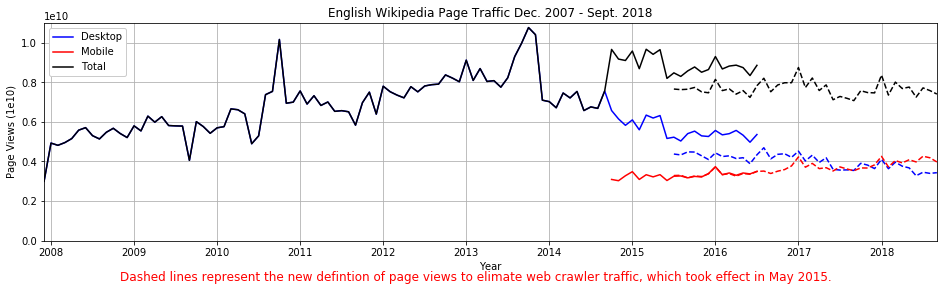

In [12]:
# Defines plot data
plot_data = csv_df
plot_data['YYYYMM'] = YYYYMM

# Finds unique x-axis labels (year) and their first index
locs = []
for i in np.unique(plot_data['year']):
    locs.append(list(plot_data['year']).index(i))
    
# Defines plot features
plt.rcParams["figure.figsize"] = (16, 4)
fig, ax = plt.subplots()
ax.set(xlabel ='Year', ylabel='Page Views (1e10)',
       title ='English Wikipedia Page Traffic Dec. 2007 - Sept. 2018')
plt.suptitle('Dashed lines represent the new defintion of page views to elimate web crawler traffic, which took effect in May 2015.', \
             y = .02, color='red');

# Defines X-axis tick labels and locations
plt.xticks(locs[1:], np.unique(plot_data['year'][1:]))

# Plots legacy data
plt.plot('YYYYMM', 'pagecount_desktop_views', 'b-',  data = plot_data)
plt.plot('YYYYMM', 'pagecount_mobile_views', 'r-', data = plot_data)
plt.plot('YYYYMM', 'pagecount_all_views', 'k-', data = plot_data)

# Plots Pageviews data
plt.plot('YYYYMM', 'pageviews_desktop_views', 'b--', data = plot_data)
plt.plot('YYYYMM', 'pageviews_mobile_views', 'r--', data = plot_data)
plt.plot('YYYYMM', 'pageviews_all_views', 'k--', data = plot_data)

# More plotting parameters
plt.legend(['Desktop','Mobile','Total'], loc=2, framealpha=1)
plt.xlim(('200712','201809'))
plt.ylim((0, 1.1e10))
plt.grid(True)

# Saves image file
fig.savefig('en-wikipedia_traffic_2000712-201809.png', bbox_inches = "tight")